# Essential dynamics

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import tqdm
import seaborn as sns
import os
import colorsys
import pickle

from typing import Dict, Iterable
from sklearn.decomposition import PCA
from collections import defaultdict

sns.set_style("white")

plt.rcParams["figure.dpi"] = 300

In [2]:
MODEL_SEED = 1
steps = range(0, 500_000, 10)[::10]
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
models = torch.load(f"../models.pt", map_location=DEVICE)
models = models[MODEL_SEED]

In [3]:
TRANSITIONS = [
    (0, 1500, "R1"),
    (1500, 40_000, "R2"),
    # (7_500, 40000, 'R3'),
    (40000, 320000, "R3"),
    # (120000, 320000, 'R5'),
    (320000, 500000, "R4"),
]


def gen_transition_colors(types):
    """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
    num_type_a = sum([t == "A" for t in types])
    num_type_b = sum([t == "B" for t in types])
    num_other = sum([t == "Other" for t in types])

    type_a_palette = sns.color_palette("Oranges_r", num_type_a)
    type_b_palette = sns.color_palette("Blues_r", num_type_b)
    other_palette = sns.color_palette("Greys_r", num_other)

    palette = []

    for t in types:
        if t == "A":
            palette.append(type_a_palette.pop())
        elif t == "B":
            palette.append(type_b_palette.pop())
        else:
            palette.append(other_palette.pop())

    return palette


def get_transition_type(transition):
    if len(transition) == 4:
        return transition[-1]

    if "A" in transition[-1]:
        return "A"

    if "B" in transition[-1]:
        return "B"

    return "Other"


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)

    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)

    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255

    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]

    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb


transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

In [4]:
def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next(
            (
                i
                for i, transition in enumerate(transitions)
                if transition[0] <= step < transition[1]
            ),
            None,
        )
        transition_indices.append(index if index is not None else -1)

    return transition_indices


def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]


def plot_explained_variance(
    pca, title="Explained Variance", ax: plt.Axes = None, num_pca_components=None
):
    num_pca_components = num_pca_components or len(pca.explained_variance_ratio_)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(
        range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components]
    )

    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha="center", va="bottom")

    ax.set_title(title)
    ax.set_xlabel("PC")
    ax.set_ylabel("Explained Variance")

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))


def plot_multiple_slices(
    steps,
    samples,
    pca,
    transitions,
    highlighted_steps=None,
    connect_dots=False,
    palette="tab10",
    alpha=0.8,
    save=False,
    line_color="auto",
):
    transition_idxs = get_transition_indices(steps, transitions)
    if highlighted_steps is None:
        highlighted_steps = list(map(get_nearest_step, [t[0] for t in transitions][1:]))

    num_pca_components = samples.shape[-1]

    num_pca_combos = (num_pca_components * (num_pca_components - 1)) // 2

    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c="black", alpha=0.2)

            sns.scatterplot(
                x=samples[:, i],
                y=samples[:, j],
                hue=transition_idxs,
                palette=palette,
                s=50,
                alpha=alpha,
                ax=axes[I],
                legend=False,
            )
            axes[I].set_xlabel(f"PC {i}")
            axes[I].set_ylabel(f"PC {j}")
            axes[I].set_title(f"PC {i} vs PC {j}")

            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(
                    samples[k, i],
                    samples[k, j],
                    str(step),
                    fontsize=8,
                    ha="right",
                    va="bottom",
                    alpha=0.8,
                )

            I += 1

    plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)
    cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)
    legend_ax = axes[0]
    scatter_proxy = [
        plt.Line2D([0], [0], linestyle="none", marker="o", alpha=alpha, color=cmap[i])
        for i in range(len(transitions))
    ]
    legend_labels = [label for _, _, label in transitions]
    legend_ax.legend(
        scatter_proxy,
        legend_labels,
        loc="center",
        ncol=1,
        frameon=False,
        bbox_to_anchor=(-0.5, 0.5),
        title="Developmental Stages",
    )
    plt.tight_layout(
        rect=[0, 0, 0.9, 1]
    )  # Adjust the right side to make room for the colorbar
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    fig.set_facecolor("white")

In [5]:
from devinterp.mechinterp.hooks import hook


def extract_activations_over_checkpoints(
    models: Iterable[nn.Module], dataloader, *paths
):
    def eval_activations(model):  # TODO likely doesn't work for large dataloaders
        model.to(DEVICE)
        hooked_model = hook(model, *paths)
        all_activations = defaultdict(list)
        for xs, ys in dataloader:
            xs, ys = xs.to(model.device), ys.to(model.device)
            outputs, activations = hooked_model.run_with_cache(xs, ys)
            activations[""] = outputs
            for k in activations:
                all_activations[k].append(activations[k].to(model.device))
        all_activations = {k: torch.cat(v) for k, v in all_activations.items()}
        return {
            k: v.detach().cpu().numpy()
            for k, v in all_activations.items()
            if (k in paths or k == "") and v is not None
        }

    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(
    models: Iterable[nn.Module], dataloader, *paths, normalize=False
):
    evals: Dict[str, list] = defaultdict(list)
    for activations in extract_activations_over_checkpoints(models, dataloader, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)
            evals[path].append(activation)

    return {k: np.array(v) for k, v in evals.items()}

In [6]:
from torch.utils.data import DataLoader

all_outputs = []
only_xs = []
only_ys = []

# Outputs of token sequence transformer
outputs = []
only_x_outputs = []
only_y_preds = []


BATCH_SIZE = 1024

dataset = torch.load('ED_dataset.pt')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
# CORE CODE
activations_trace = get_vectorized_activations_trace(
    models, dataloader, "token_sequence_transformer", normalize=False
)

activations = activations_trace["token_sequence_transformer"]
vec_activations = activations.reshape(len(activations), -1)
outputs.append(vec_activations)
print(activations.shape)
only_x_outputs.append(activations[:, :, ::2, :].reshape(len(vec_activations), -1))

y_preds = activations_trace[""]
only_y_preds.append(y_preds.reshape(len(y_preds), -1))

all_outputs.append(np.concatenate(outputs, axis=1))
only_xs.append(np.concatenate(only_x_outputs, axis=1))
only_ys.append(np.concatenate(only_y_preds, axis=1))

In [ ]:
def plot_essential_dynamics_grid(steps, all_samples, transitions, palette='tab10', save=False, figsize=(20, 4), num_pca_components=3, max_step=None, normalize=False, labels=None, special=[]):
    num_samples = len(all_samples)  

    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    fig, all_axes = plt.subplots(num_samples, num_pca_combos + 1, figsize=figsize)
    
    if num_samples == 1:
        all_axes = [all_axes]

    labels = labels or [f"Model {i+1}" for i in range(num_samples)]

    for samples_idx, _samples in enumerate(tqdm.tqdm(all_samples, desc="Plotting...")):
        if max_step is not None:
            max_step_idx = steps.index(max_step)
            _samples = _samples[:max_step_idx, :]
        if normalize:
            _samples = _samples / np.linalg.norm(_samples, axis=1, keepdims=True)

        pca = PCA(n_components=min(10 * num_pca_components, *np.shape(_samples)))
        samples = pca.fit_transform(_samples)   

        axes = all_axes[samples_idx]

        # Ensure ax is iterable by converting to a list if there's only one subplot
        if num_pca_components == 2:
            axes = [axes]

        special_transforms = [
            pca.transform(s) for s, _ in special
        ]

        I = 0
        for i in range(1, num_pca_components):
            for j in range(i):
                sns.scatterplot(x=samples[:, i], y=samples[:, j], ax=axes[I], alpha=0.5, color="gray", s=10, legend=False)
                for k, (start, end, stage) in enumerate(transitions):
                    start_idx = steps.index(start)
                    end_idx = steps.index(end) + 1
                    axes[I].plot(samples[start_idx:end_idx, i], samples[start_idx:end_idx, j])

                for s, (_, settings) in zip(special_transforms, special):
                    style = settings.get("style", 'r+')
                    axes[I].plot(s[:, i], s[:, j], style)

                if not transitions:
                    axes[I].plot(samples[:, i], samples[:, j])

                axes[I].set_xlabel(f'PC {i+1}')
                axes[I].set_ylabel(f'PC {j+1}')
                axes[I].set_title(f'PC {j+1} vs PC {i+1}')

                I += 1

        axes[0].set_ylabel(f"{labels[samples_idx]}\n\nPC 1")

        plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)

    plt.tight_layout(rect=[0, 0, 1, 1])

    if transitions:
        legend_ax = fig.add_axes([0.1, -0.03, 0.95, 0.05])  # Adjust these values as needed

        handles = [plt.Line2D([0], [0], color=sns.color_palette(palette)[i], linestyle='-') for i in range(len(transitions))]
        labels = [label for _, _, label in transitions]
        legend_ax.legend(handles, labels, loc='center', ncol=len(labels), frameon=False)
        legend_ax.axis('off')  # Turn off axis lines and labels

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        with open(save + ".pkl", "wb") as f:
            pickle.dump((pca, samples), f)

        plt.savefig(save + ".png")

    fig.set_facecolor('white')

    return fig

[(0, 900, 'A')]
[(0, 1500, 'R1'), (1200, 10000, 'B')]


Plotting...:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting...: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
<ipython-input-10-a3ae7535dca0>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-10-a3ae7535dca0>:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


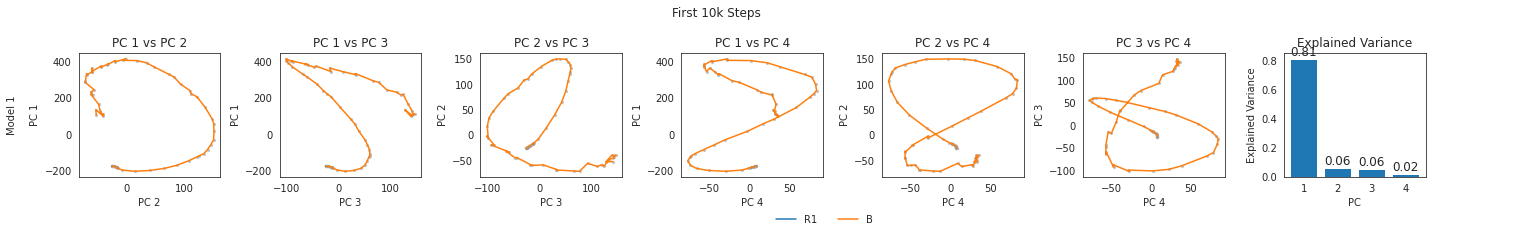

[(0, 1500, 'R1'), (1500, 40000, 'R2'), (40000, 320000, 'R3'), (60001, 100000, 'D')]


Plotting...: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
<ipython-input-10-a3ae7535dca0>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-10-a3ae7535dca0>:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


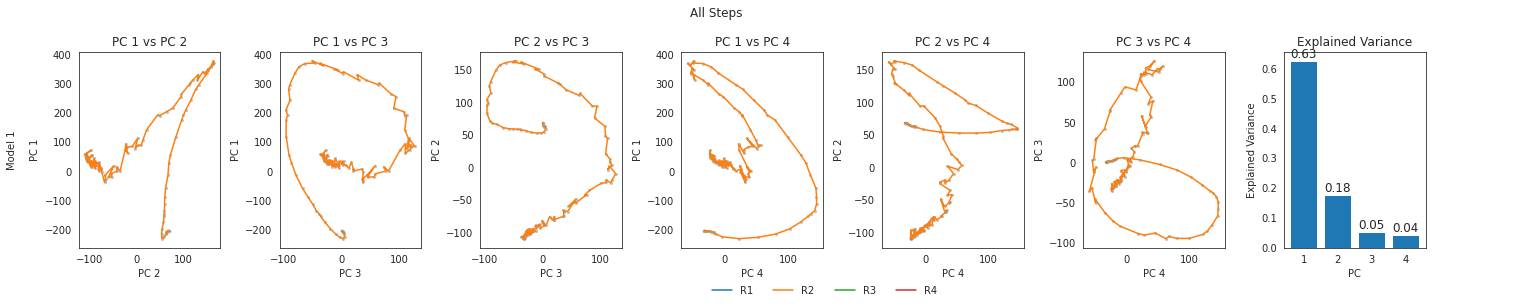

In [ ]:
save = "../data/LMinf1-behavioral-ED"

_all_outputs = [all_outputs[0][:,]]

special = []
CLOSEST_TRANSITIONS = [
    (get_nearest_step(t0), get_nearest_step(t1), label) for t0, t1, label in TRANSITIONS
]
truncated_transitions = CLOSEST_TRANSITIONS[:1]
truncated_transitions[-1] = (0, steps[10 - 1], "A")
print(truncated_transitions)


truncated_transitions = CLOSEST_TRANSITIONS[:2]

truncated_transitions[-1] = (1200, steps[100], "B")
print(truncated_transitions)

fig = plot_essential_dynamics_grid(
    steps[:101],
    [_all_outputs[0][:101]],
    truncated_transitions,
    num_pca_components=4,
    figsize=(20, 3),
    special=special,
)
fig.suptitle("First 10k Steps")
plt.tight_layout()
plt.show()

truncated_transitions = CLOSEST_TRANSITIONS[:4]
truncated_transitions[-1] = (60001, steps[1000], "D")
print(truncated_transitions)


fig = plot_essential_dynamics_grid(
    steps,
    _all_outputs,
    CLOSEST_TRANSITIONS,
    num_pca_components=4,
    figsize=(20, 4),
    special=special,
    save=save,
)
fig.suptitle("All Steps")
plt.tight_layout()
plt.show()